In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
import skimage.draw

TRAIN_PATH = 'train/'
TEST_PATH = 'val/'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

sys.path.append('./mrcnn')

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
class MarkConfig(Config):
    """Configuration for training on the cell dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "dot"

    GPU_COUNT = 2
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 3 + 1  # Background + cell

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 150
    
    # set validation steps 
    VALIDATION_STEPS = 50
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = MarkConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class MarkDataset(utils.Dataset):

    def load_shapes(self, subset):
        # Add classes. We have only one class to add.
        self.add_class("dot", 1, "greendot")
        self.add_class("dot", 2, "reddot")
        self.add_class("dot", 3, "blackdot")

        # Train or validation dataset?
        dataset_dir = "."
        
        if subset == 'train':
            annotations = json.load(open('train.json', 'r'))
        else:
            annotations = json.load(open('val.json', 'r'))
        
        # Add images annotated with Labelbox 
        for a in annotations:
            polygons = []
            class_ids = []
            
            # Get Image Size 
            image_path = os.path.join(dataset_dir, a['External ID'])
            image = imread(image_path)
            height, width = image.shape[:2]
            
#             print (a['Label'])
            
            if 'greendot' in a['Label']:
                polys = [r['geometry'] for r in a['Label']['greendot']] 
                
                for i, p in enumerate(polys):
                    x_points = [x['x'] for x in p]
                    y_points = [y['y'] for y in p]
                    polygons.append({'all_points_x': x_points, 'all_points_y': y_points})
                    class_ids.append(1)

            if 'reddot' in a['Label']:
                polys = [r['geometry'] for r in a['Label']['reddot']] 

                for i, p in enumerate(polys):
                    x_points = [x['x'] for x in p]
                    y_points = [y['y'] for y in p]
                    polygons.append({'all_points_x': x_points, 'all_points_y': y_points})
                    class_ids.append(2)

            if 'blackdot' in a['Label']:
                polys = [r['geometry'] for r in a['Label']['blackdot']] 

                for i, p in enumerate(polys):
                    x_points = [x['x'] for x in p]
                    y_points = [y['y'] for y in p]
                    polygons.append({'all_points_x': x_points, 'all_points_y': y_points})
                    class_ids.append(3)

            self.add_image(
                "dot",
                image_id=a['External ID'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)
        
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "dot":
            return super(self.__class__, self).load_mask(image_id)
        

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        class_ids = info['class_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.array(class_ids, dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if (info["source"] != "greendot" or 
            info["source"] != "reddot" or 
            info["source"] != "blackdot"):
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
# Training dataset
dataset_train = MarkDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()


# Validation dataset
dataset_val = MarkDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

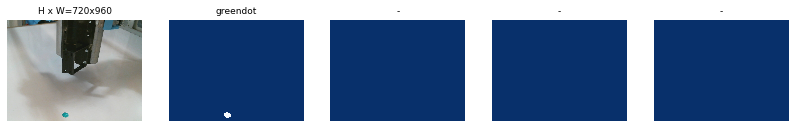

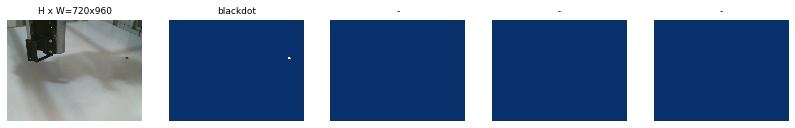

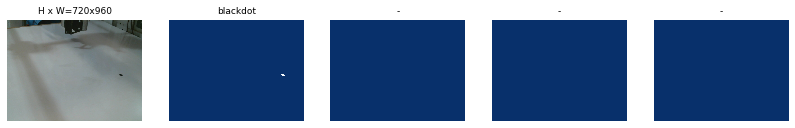

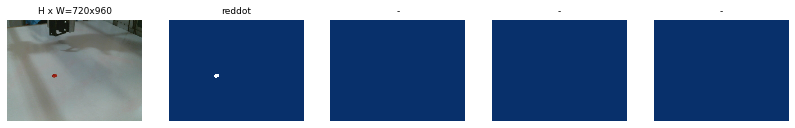

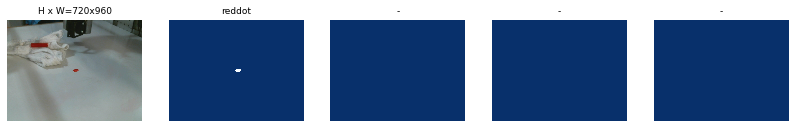

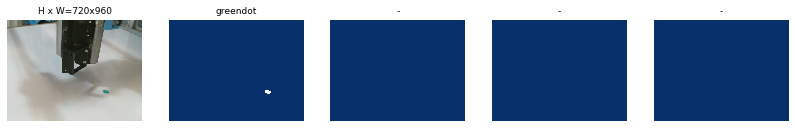

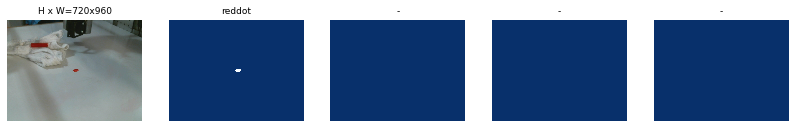

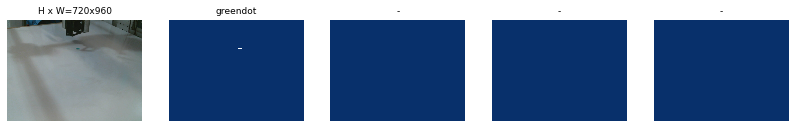

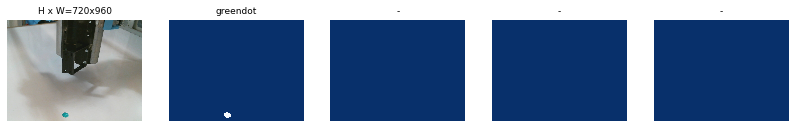

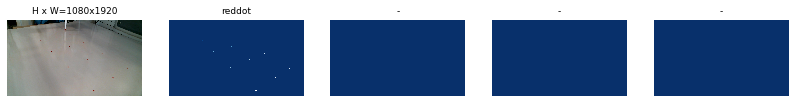

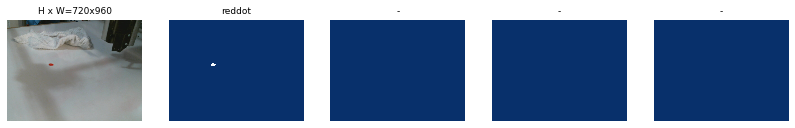

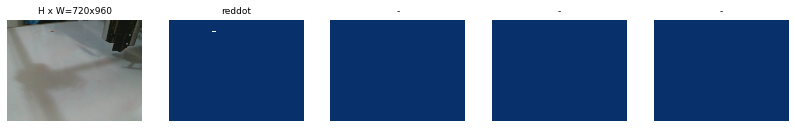

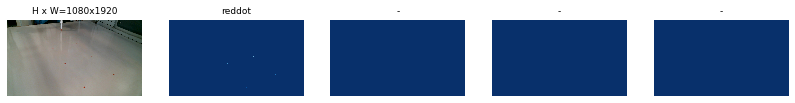

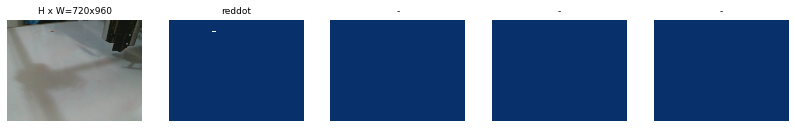

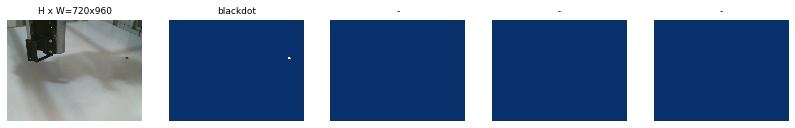

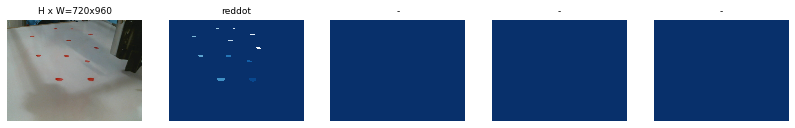

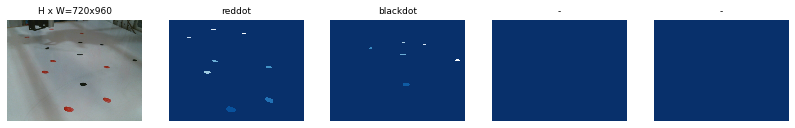

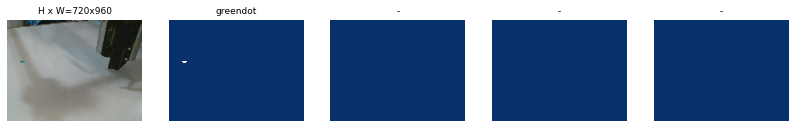

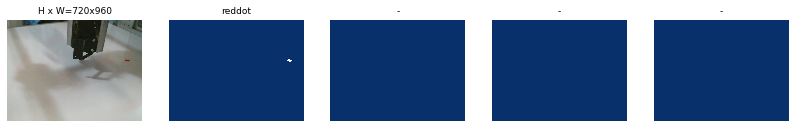

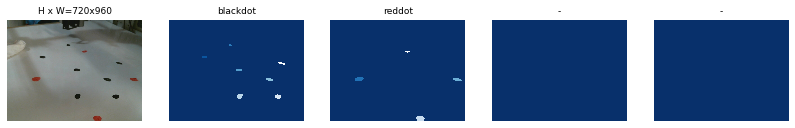

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 20)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/caleb/Desktop/caminterp/logs/dot20190728T1318/mask_rcnn_dot_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_ma

/home/caleb/.conda/envs/gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/caleb/.conda/envs/gpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/3
150/150 [==============================] - 139s 926ms/step - loss: 1.2077 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.3341 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.3133 - mrcnn_mask_loss: 0.3728 - val_loss: 0.8688 - val_rpn_class_loss: 0.0292 - val_rpn_bbox_loss: 0.3205 - val_mrcnn_class_loss: 0.0562 - val_mrcnn_bbox_loss: 0.2495 - val_mrcnn_mask_loss: 0.2134
Epoch 2/3
150/150 [==============================] - 74s 494ms/step - loss: 0.5457 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1901 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1705 - val_loss: 0.9868 - val_rpn_class_loss: 0.0149 - val_rpn_bbox_loss: 0.2791 - val_mrcnn_class_loss: 0.0713 - val_mrcnn_bbox_loss: 0.3182 - val_mrcnn_mask_loss: 0.3033
Epoch 3/3
150/150 [==============================] - 75s 501ms/step - loss: 0.4830 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1845 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1487 - val_loss: 0.6837 - val_rpn_cla

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all")

model_path = "dotmodel_w_align.h5"
model.keras_model.save_weights(model_path)


Starting at epoch 3. LR=0.0001

Checkpoint Path: /home/caleb/Desktop/caminterp/logs/dot20190728T1318/mask_rcnn_dot_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_br

In [11]:
class InferenceConfig(MarkConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
model_path = 'dotmodel_w_align.h5'
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  dotmodel_w_align.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  177.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (7,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (7, 4)                min:  204.00000  max:  926.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


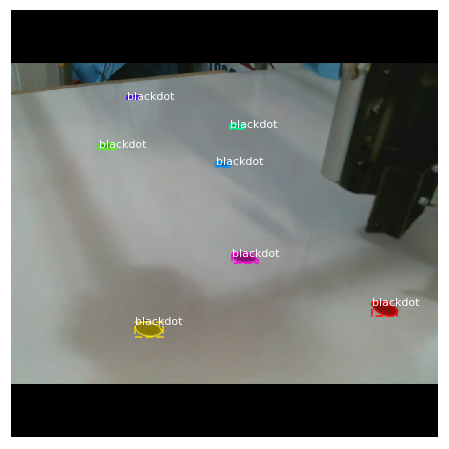

In [115]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

<class 'imageio.core.util.Array'>
(1080, 1920, 3)
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  186.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   59.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


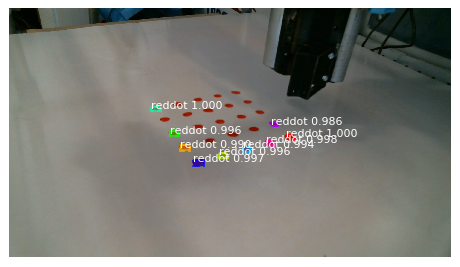

In [18]:
# from matplotlib.image import imread
img = skimage.io.imread('WIN_20190725_13_57_04_Pro.jpg')
print(type(img))
print(img.shape)

results = model.detect([img], verbose=1)

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [19]:
def get_mark_center(rois):
    centroids = []
    for dot in rois:
        centroids.append(np.stack([
            dot[1] + ((dot[3] - dot[1]) / 2.0),
            dot[0] + ((dot[2] - dot[0]) / 2.0),
        ], -1))
    return centroids

def find_dots(model):
    results = model.detect([original_image], verbose=1)
    r = results[0]
    if len(r['rois']) > 0:
        centroids = get_mark_center(r['rois'])
        return centroids, original_image, r

In [20]:
centroids, orig_frame, r = find_dots(model)
print(centroids)
print(centroids[0])
print(centroids[1])
print(centroids[2])


NameError: name 'original_image' is not defined

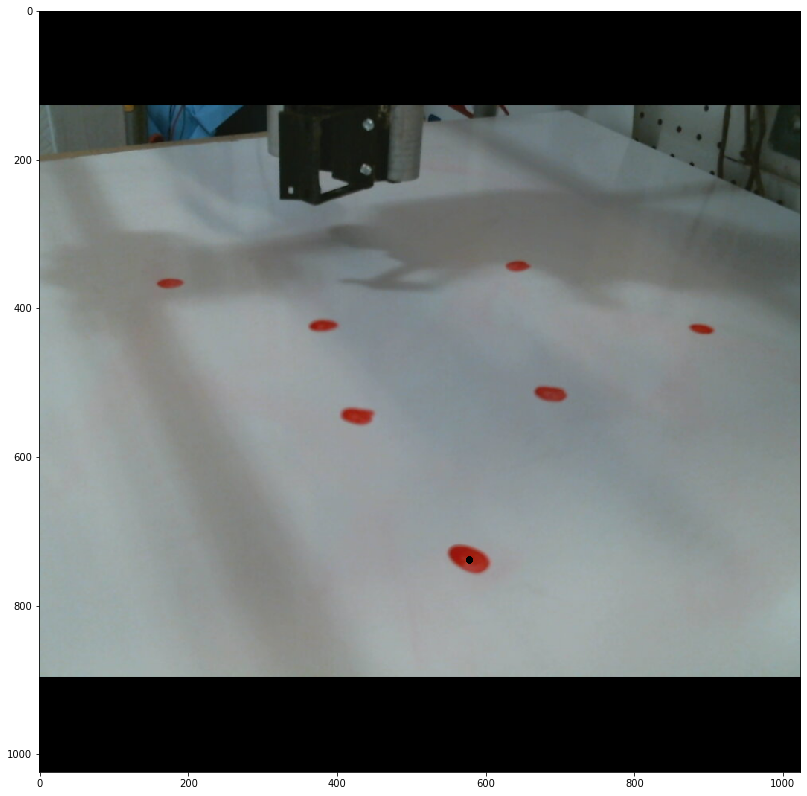

In [70]:
from skimage import draw
import matplotlib.pyplot as plt
def visualize_marker_centers(img, centers, color=0):
    for center in centers:
        res = img.copy()
        rr, cc = draw.circle(center[1], center[0], radius=5, shape=img.shape)
        res[rr, cc] = color
        return res
plt.imshow(visualize_marker_centers(original_image, centroids, [0, 0, 0]))
plt.gcf().set_size_inches(20, 14)